In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# import matplotlib to show plots inline.
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os

import astropy.units as u
import matplotlib as mpl
import sys 
sys.path.append("..")
from plot_OpSims import plot_OpSims_hist_extremes

In [3]:
# import maf python modules
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

In [4]:
# import convenience functions
import sys 
sys.path.append("../../LSST_OpSim")
from Scripts_NBs.opsimUtils import *

## Load the results
We first load the results of the run into memory. We will read jointly the FBS v1.5 and FBS v1.6 results, and will differentiate at the time of plotting.

In [5]:
NSIDE = 64
your_username = "rjassef"
folder_mafoutput = "EM5_depths_{0:d}".format(NSIDE)
resultDbPath = '/home/idies/workspace/Storage/{0}/persistent/MAFOutput/{1}'.format(
    your_username, folder_mafoutput)
metricDataPath = '/home/idies/workspace/Storage/{0}/persistent/MAFOutput/{1}/MetricData/'.format(
    your_username, folder_mafoutput)

In [6]:
# get a dictionary of resultDb from given directory
resultDbs = getResultsDbs(resultDbPath)

In [7]:
# retrieve metricBundles for each opsim run and store them in a dictionary
bundleDicts_raw = dict()
for runName in resultDbs:
    bundleDicts_raw[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSID

In [8]:
#Rearrange the bundleDicts_raw dictionary so that the keys are always the same as for the first run.
dbRuns = list(bundleDicts_raw.keys())
Keys = list(bundleDicts_raw[dbRuns[0]].keys())
bundleDicts = dict()
for runName in dbRuns:
    bundleDicts[runName] = dict()
    Keys_raw = bundleDicts_raw[runName]
    for Key in Keys:
        for Key_raw in Keys_raw:
            if Key[1]==Key_raw[1]:
                bundleDicts[runName][Key] = bundleDicts_raw[runName][Key_raw]

In [9]:
# check keys
dbRuns = list(resultDbs.keys())
bd_keys = list(bundleDicts[dbRuns[0]].keys())
print(bd_keys)

[(1, 'ExgalM5_with_cuts_AGN_g'), (2, 'ExgalM5_with_cuts_AGN_u')]


In [10]:
uKey, gKey = (2, 'ExgalM5_with_cuts_AGN_u'), (1, 'ExgalM5_with_cuts_AGN_g')

In [11]:
#Make sure that the plots folder exists.
plots_folder = "plots_all_opsims_extremes_{0:d}".format(NSIDE)
if not os.path.exists(plots_folder):
    os.mkdir(plots_folder)

## Plot the 3 sigma u-band depths 5 sigma g-band depths.

Since the metric only calculated the 5 sigma depths, we will need to convert to 3 sigma assuming Gaussian noise, namely we assume that 

$$m_{\rm lim, 5\sigma} = -2.5 \log ( 5~\delta f_{1\sigma} ) + C$$

So that 

$$m_{\rm lim, 3\sigma} = -2.5 \log ( 3~\delta f_{1\sigma} ) + C = m_{\rm lim, 5\sigma} + 2.5 \log (5/3)$$

#### u-band

In [12]:
def mlim_3sigma(mlim_5sigma):
    return mlim_5sigma + 2.5*np.log10(5./3.)

footprint_stuck_rollingv1.5_10yrs 25.63183128525153
filterdist_indx4_v1.5_10yrs 26.64337935736984


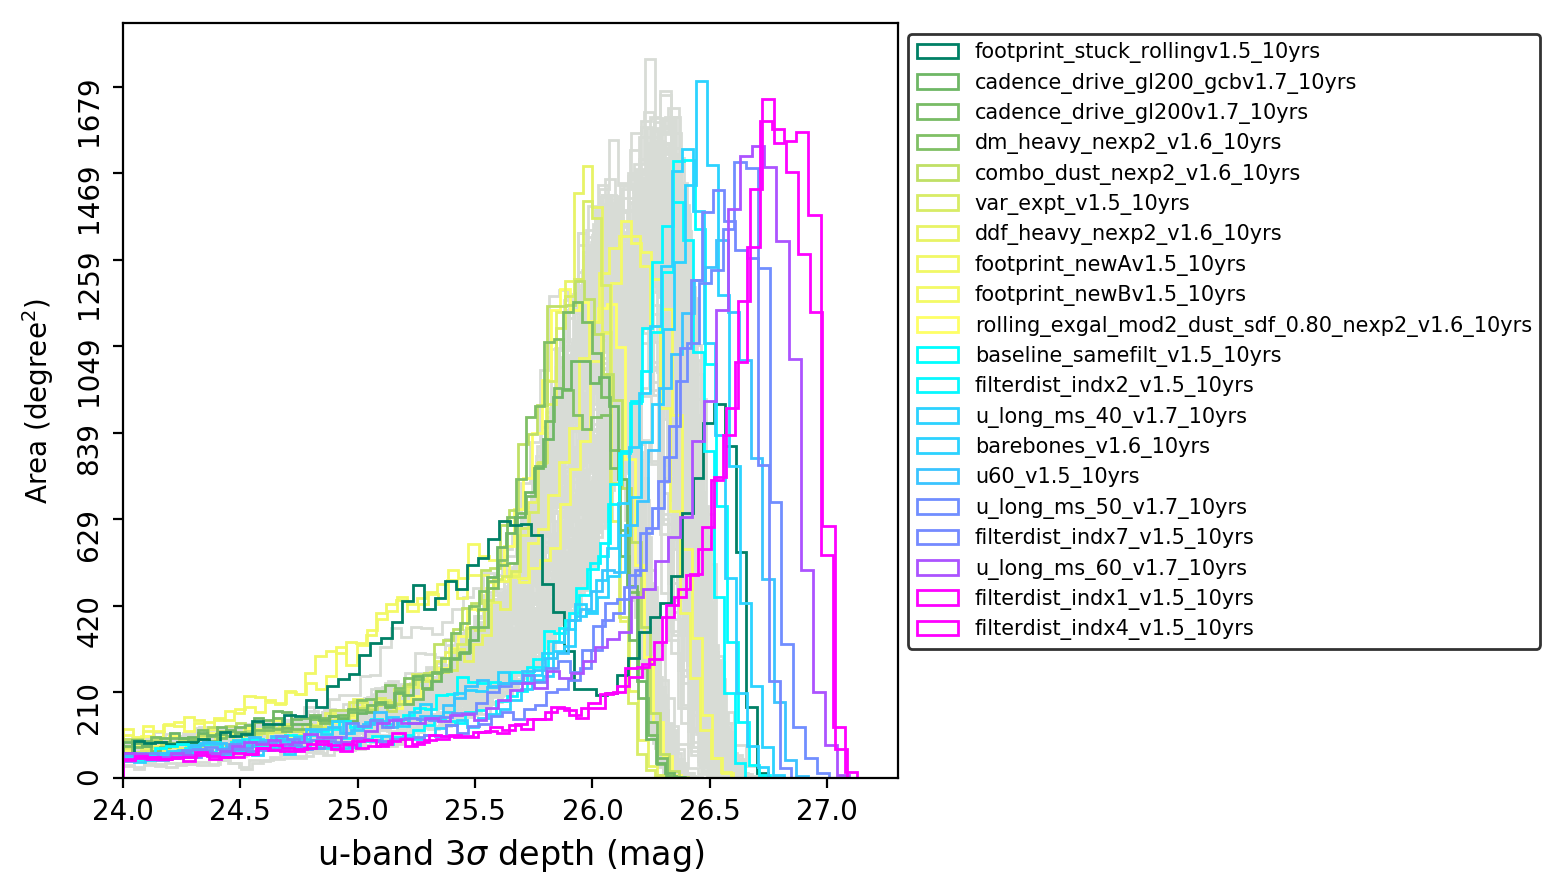

In [13]:
data_func = mlim_3sigma
xlabel = r"u-band 3$\sigma$ depth (mag)"
healpix_pixarea = bundleDicts[dbRuns[0]][uKey].slicer.pixArea * u.sr

plot_OpSims_hist_extremes(uKey, bundleDicts, data_func=data_func, figsize=(5,5), 
                          healpix_pixarea=healpix_pixarea, datamin=24, datamax=27.3, 
                          xlabel=xlabel, color_map_bottom=mpl.cm.summer,
                          color_map_top=mpl.cm.cool, percentile=5.0)
plt.savefig("{0}/uband_3sigma_depth.png".format(plots_folder), dpi=200)#, bbox_inches='tight')

#### g-band

footprint_stuck_rollingv1.5_10yrs 26.223543136465118
filterdist_indx3_v1.5_10yrs 27.171889055461413


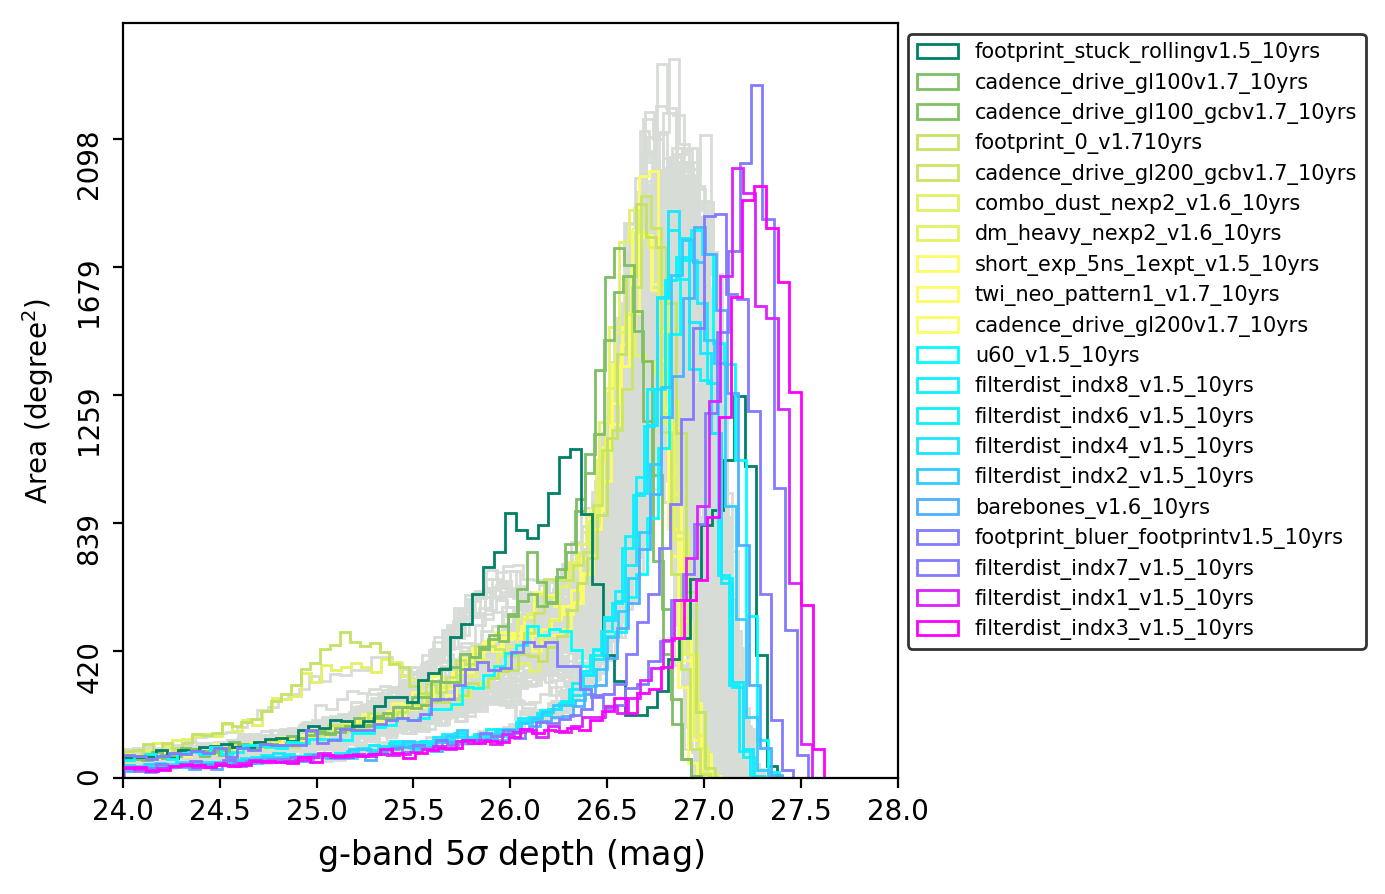

In [14]:
data_func = None
xlabel = r"g-band 5$\sigma$ depth (mag)"
healpix_pixarea = bundleDicts[dbRuns[0]][gKey].slicer.pixArea * u.sr

plot_OpSims_hist_extremes(gKey, bundleDicts, data_func=data_func, figsize=(5,5), 
                          healpix_pixarea=healpix_pixarea, datamin=24, datamax=28, 
                          xlabel=xlabel, color_map_bottom=mpl.cm.summer,
                          color_map_top=mpl.cm.cool, percentile=5.0)
plt.savefig("{0}/gband_5sigma_depth.png".format(plots_folder), dpi=200, bbox_inches='tight')

## Plot as a fuction of L* at z=2.5

We first estimate the u and g magnitude of an Lstar quasar at z=2.5. We do this by using the Shen et al. (2020) luminosity function to calculate Lbol_star at z=2.5. We then use the conversion from Lbol to L1450 provided by Shen et al. (2020). Finally, we take a quasar template, redshift it to z=2.5, normalize it to L1450 (calculated using a redshifted tophat template as described in Shen et al.) and calcute its magnitudes in the SDSS u and g bands. There are two options of templatates so far:

* vanden Berk et al. (2001) - All the manipulation of the vanden Berk et al. template is done using pysynphot, which is not available in SciServer. 

* Assef et al. (2010) - All manipulation is done with LRT, which I have not installed in my SciServer workspace (might actually not be possible).

We assume a Planck13 astropy cosmology in either case. The pre-computed magnitude-redshift tables are found in the folder ../mstar_estimates. 

In [15]:
#vanden Berk et al. (2001)
data = np.loadtxt("../mstar_estimates/mstar_z.vandenberk.dat")

#Assef et al. (2010)
#data = np.loadtxt("../mstar_estimates/mstar_z.lrt.dat")

mstar = dict()
filters = ['u','g','r','i','z','y']
for k, filter in enumerate(filters):
    mstar[filter] = np.interp([2.5], data[:,0], data[:,k+1])[0]
    print("{0:s} {1:7.3f}".format(filter, mstar[filter]))

u  21.009
g  20.161
r  20.040
i  20.024
z  19.853
y  19.634


#### u-band

In [16]:
def log_QLF_Lstar_frac_u(mlim_5sigma):
    #First, transform to 3 sigma
    mlim_3sigma = mlim_5sigma + 2.5*np.log10(5./3.)
    #Now, transform to Lstar fraction.
    return -0.4*(mlim_3sigma - mstar['u'])

filterdist_indx4_v1.5_10yrs -2.2539437429479365
footprint_stuck_rollingv1.5_10yrs -1.8493245141006114


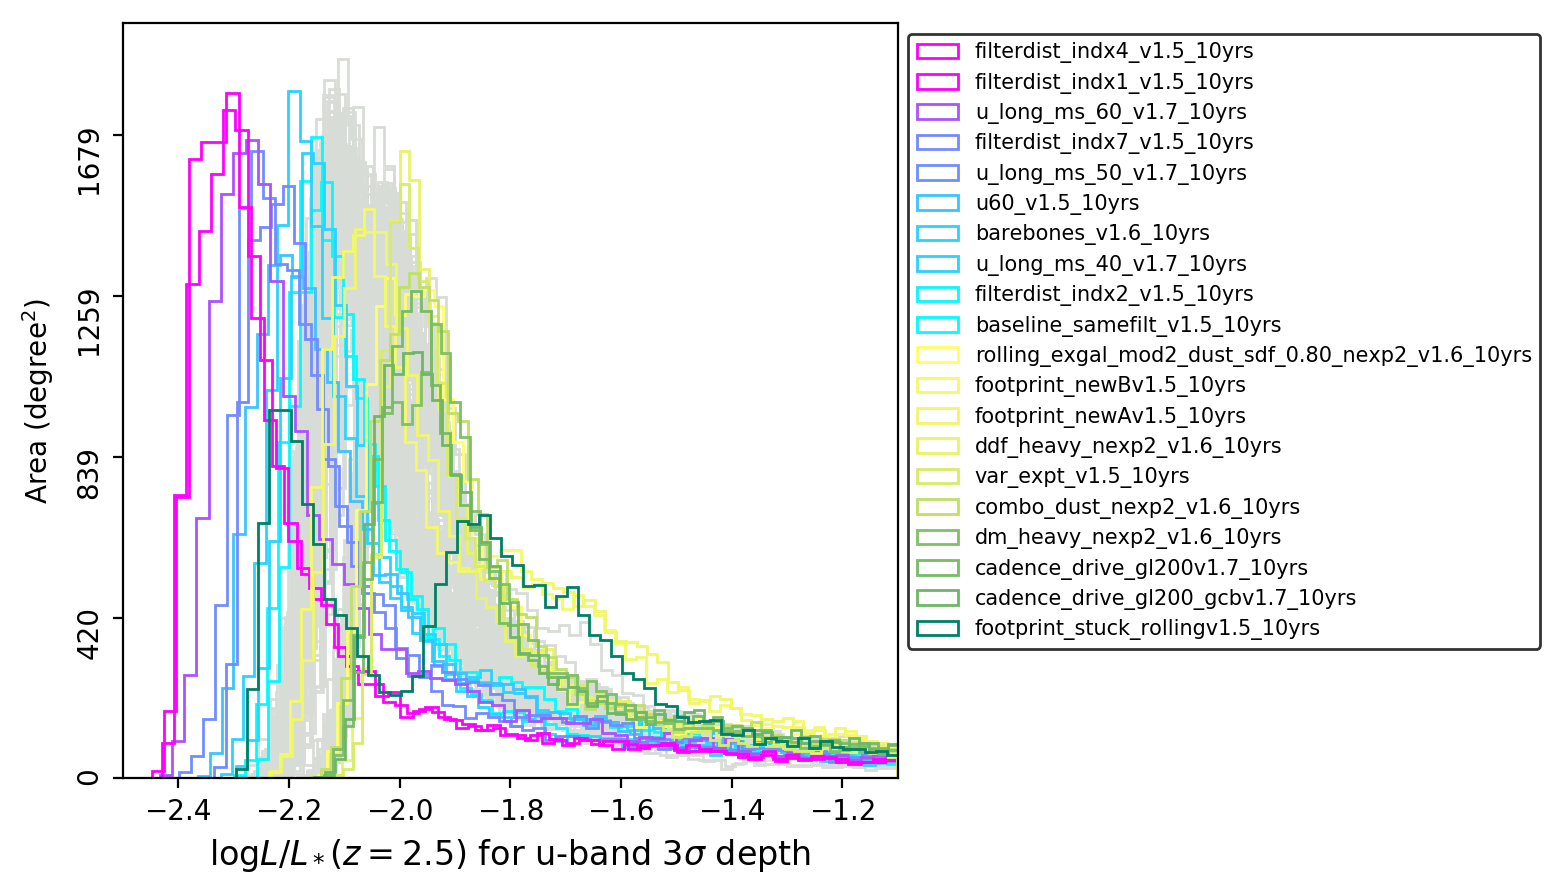

In [17]:
data_func = log_QLF_Lstar_frac_u
xlabel = r"$\log L/L_*(z=2.5)$ for u-band 3$\sigma$ depth"

healpix_pixarea = bundleDicts[dbRuns[0]][uKey].slicer.pixArea * u.sr

plot_OpSims_hist_extremes(uKey, bundleDicts, data_func=data_func, figsize=(5,5), 
                          healpix_pixarea=healpix_pixarea, datamin=-2.5, datamax=-1.1, 
                          xlabel=xlabel, color_map_bottom=mpl.cm.cool_r,
                          color_map_top=mpl.cm.summer_r, percentile=5.0)
plt.savefig("{0}/uband_3sigma_L_Lstar.png".format(plots_folder), dpi=200, bbox_inches='tight')

#### g-band

In [18]:
def log_QLF_Lstar_frac_g(mlim_5sigma):
    return -0.4*(mlim_5sigma - mstar['g'])

filterdist_indx3_v1.5_10yrs -2.8043876221845654
footprint_stuck_rollingv1.5_10yrs -2.425049254586046


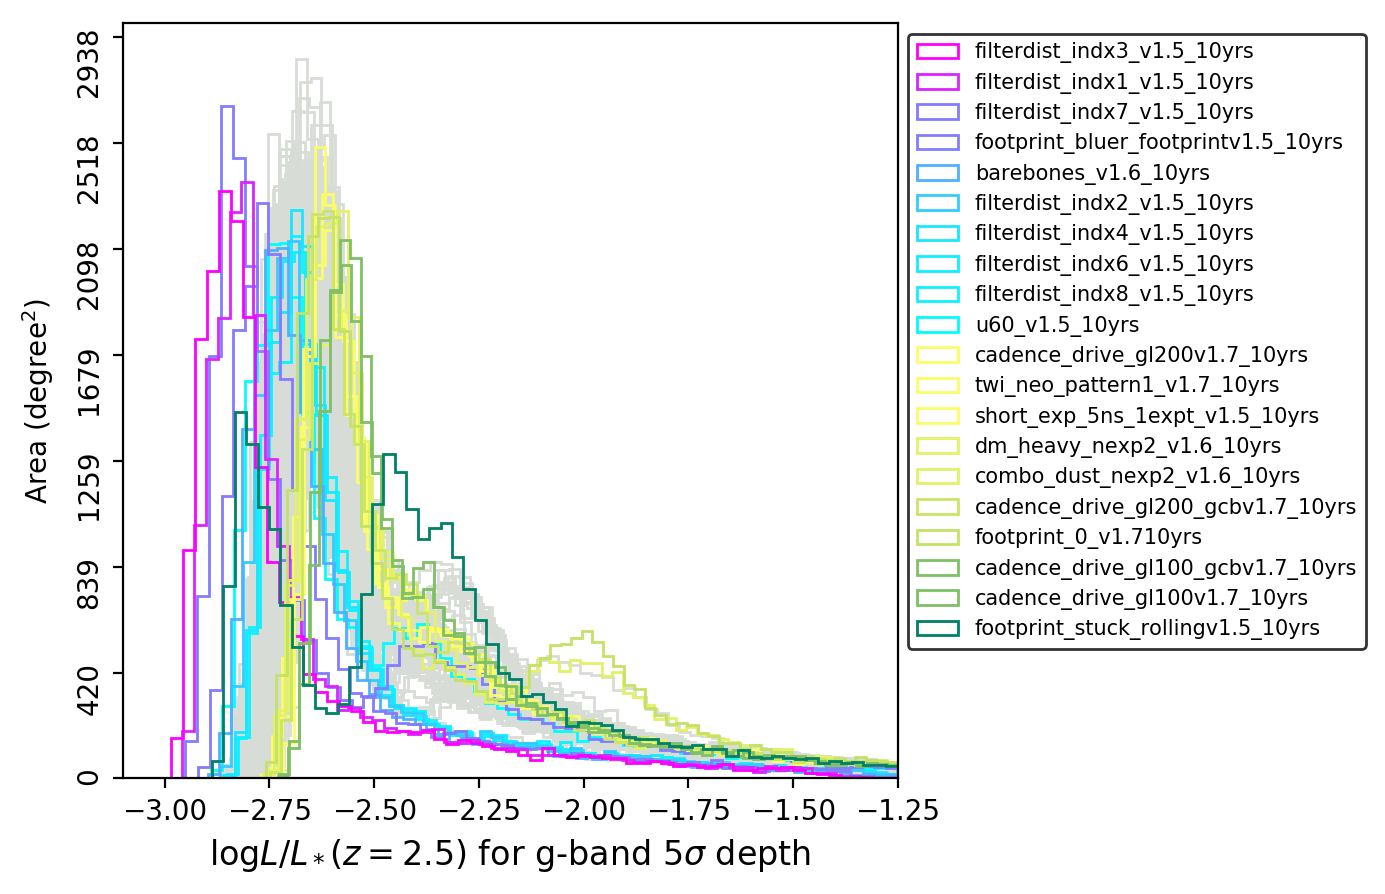

In [19]:
data_func = log_QLF_Lstar_frac_g
xlabel = r"$\log L/L_*(z=2.5)$ for g-band 5$\sigma$ depth"
healpix_pixarea = bundleDicts[dbRuns[0]][gKey].slicer.pixArea * u.sr

plot_OpSims_hist_extremes(gKey, bundleDicts, data_func=data_func, figsize=(5,5), 
                          healpix_pixarea=healpix_pixarea, datamin=-3.1, datamax=-1.25, 
                          xlabel=xlabel, color_map_bottom=mpl.cm.cool_r,
                          color_map_top=mpl.cm.summer_r, percentile=5.0)
plt.savefig("{0}/gband_5sigma_L_Lstar.png".format(plots_folder), dpi=200, bbox_inches='tight')